# 自注意力和位置编码
:label:`sec_self-attention-and-positional-encoding`

在深度学习中，我们经常使用卷积神经网络（CNN）或循环神经网络（RNN）对序列进行编码。
想象一下，有了注意力机制之后，我们将词元序列输入注意力池化中，
以便同一组词元同时充当查询、键和值。
具体来说，每个查询都会关注所有的键－值对并生成一个注意力输出。
由于查询、键和值来自同一组输入，因此被称为
*自注意力*（self-attention）
 :cite:`Lin.Feng.Santos.ea.2017,Vaswani.Shazeer.Parmar.ea.2017`，
也被称为*内部注意力*（intra-attention） :cite:`Cheng.Dong.Lapata.2016,Parikh.Tackstrom.Das.ea.2016,Paulus.Xiong.Socher.2017`。
在本节中，我们将使用自注意力进行序列编码，以及如何使用序列的顺序作为补充信息。


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## [**自注意力**]

给定一个由词元组成的输入序列$\mathbf{x}_1, \ldots, \mathbf{x}_n$，
其中任意$\mathbf{x}_i \in \mathbb{R}^d$（$1 \leq i \leq n$）。
该序列的自注意力输出为一个长度相同的序列
$\mathbf{y}_1, \ldots, \mathbf{y}_n$，其中：

$$\mathbf{y}_i = f(\mathbf{x}_i, (\mathbf{x}_1, \mathbf{x}_1), \ldots, (\mathbf{x}_n, \mathbf{x}_n)) \in \mathbb{R}^d$$
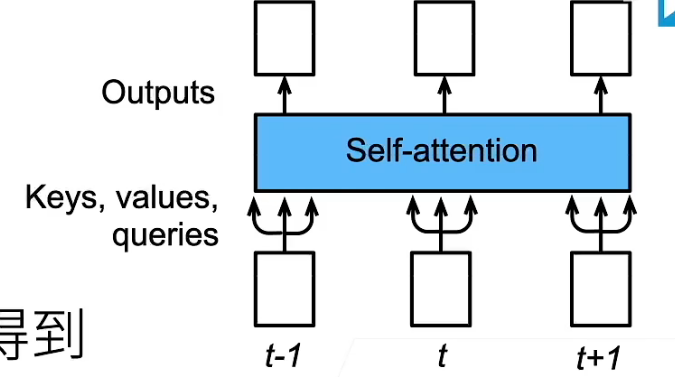
根据 :eqref:`eq_attn-pooling`中定义的注意力池化函数$f$。
下面的代码片段是基于多头注意力对一个张量完成自注意力的计算，
张量的形状为（批量大小，时间步的数目或词元序列的长度，$d$）。
输出与输入的张量形状相同。


In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

## 比较卷积神经网络、循环神经网络和自注意力
:label:`subsec_cnn-rnn-self-attention`

让我们比较下面几个架构，目标都是将由$n$个词元组成的序列映射到另一个长度相等的序列，其中的每个输入词元或输出词元都由$d$维向量表示。具体来说，我们将比较的是卷积神经网络、循环神经网络和自注意力这几个架构的计算复杂性、顺序操作和最大路径长度。请注意，顺序操作会妨碍并行计算，而任意的序列位置组合之间的路径越短，则能更轻松地学习序列中的远距离依赖关系 :cite:`Hochreiter.Bengio.Frasconi.ea.2001`。

![比较卷积神经网络（填充词元被忽略）、循环神经网络和自注意力三种架构](../img/cnn-rnn-self-attention.svg)
:label:`fig_cnn-rnn-self-attention`

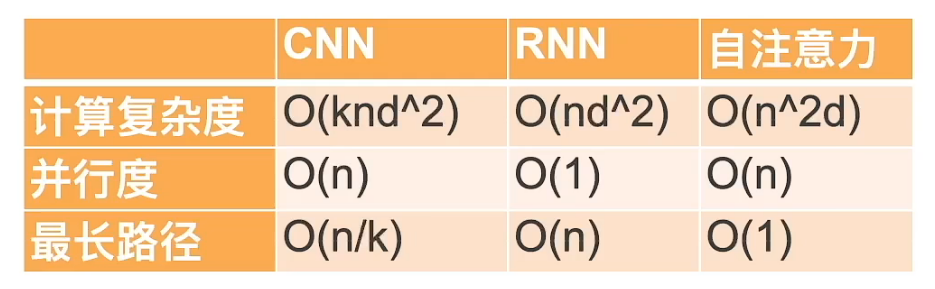
考虑一个卷积核大小为$k$的卷积层。
我们将在后面的章节中提供关于使用卷积神经网络处理序列的更多详细信息。
目前，我们只需要知道，由于序列长度是$n$，输入和输出的通道数量都是$d$，
所以卷积层的计算复杂度为$\mathcal{O}(knd^2)$。
如 :numref:`fig_cnn-rnn-self-attention`所示，
卷积神经网络是分层的，因此为有$\mathcal{O}(1)$个顺序操作，
最大路径长度为$\mathcal{O}(n/k)$。
例如，$\mathbf{x}_1$和$\mathbf{x}_5$处于
 :numref:`fig_cnn-rnn-self-attention`中卷积核大小为3的双层卷积神经网络的感受野内。

当更新循环神经网络的隐状态时，
$d \times d$权重矩阵和$d$维隐状态的乘法计算复杂度为$\mathcal{O}(d^2)$。
由于序列长度为$n$，因此循环神经网络层的计算复杂度为$\mathcal{O}(nd^2)$。
根据 :numref:`fig_cnn-rnn-self-attention`，
有$\mathcal{O}(n)$个顺序操作无法并行化，最大路径长度也是$\mathcal{O}(n)$。

在自注意力中，查询、键和值都是$n \times d$矩阵。
考虑 :eqref:`eq_softmax_QK_V`中缩放的”点－积“注意力，
其中$n \times d$矩阵乘以$d \times n$矩阵。
之后输出的$n \times n$矩阵乘以$n \times d$矩阵。
因此，自注意力具有$\mathcal{O}(n^2d)$计算复杂性。
正如我们在 :numref:`fig_cnn-rnn-self-attention`中看到的那样，
每个词元都通过自注意力直接连接到任何其他词元。
因此，有$\mathcal{O}(1)$个顺序操作可以并行计算，
最大路径长度也是$\mathcal{O}(1)$。

总而言之，卷积神经网络和自注意力都拥有并行计算的优势，
而且自注意力的最大路径长度最短。
但是因为其计算复杂度是关于序列长度的二次方，所以在很长的序列中计算会非常慢。

## [**位置编码**]
:label:`subsec_positional-encoding`

在处理词元序列时，循环神经网络是逐个的重复地处理词元的，
而自注意力则因为并行计算而放弃了顺序操作。
为了使用序列的顺序信息，我们通过在输入表示中添加
*位置编码*（positional encoding）来注入绝对的或相对的位置信息。
位置编码可以通过学习得到也可以直接固定得到。
接下来，我们描述的是基于正弦函数和余弦函数的固定位置编码
 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。

假设输入表示$\mathbf{X} \in \mathbb{R}^{n \times d}$
包含一个序列中$n$个词元的$d$维嵌入表示。
位置编码使用相同形状的位置嵌入矩阵
$\mathbf{P} \in \mathbb{R}^{n \times d}$输出$\mathbf{X} + \mathbf{P}$，
矩阵第$i$行、第$2j$列和$2j$列上的元素为：

$$\begin{aligned} p_{i, 2j} &= \sin\left(\frac{i}{10000^{2j/d}}\right),\\p_{i, 2j+1} &= \cos\left(\frac{i}{10000^{2j/d}}\right).\end{aligned}$$
:eqlabel:`eq_positional-encoding-def`

乍一看，这种基于三角函数的设计看起来很奇怪。
在解释这个设计之前，让我们先在下面的`PositionalEncoding`类中实现它。


In [4]:
#@save
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

在位置嵌入矩阵$\mathbf{P}$中，
[**行代表词元在序列中的位置，列代表位置编码的不同维度**]。
在下面的例子中，我们可以看到位置嵌入矩阵的第$6$列和第$7$列的频率高于第$8$列和第$9$列。
第$6$列和第$7$列之间的偏移量（第$8$列和第$9$列相同）是由于正弦函数和余弦函数的交替。


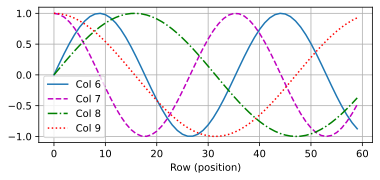

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

### 绝对位置信息

为了明白沿着编码维度单调降低的频率与绝对位置信息的关系，
让我们打印出$0, 1, \ldots, 7$的[**二进制表示**]形式。
正如我们所看到的，每个数字、每两个数字和每四个数字上的比特值
在第一个最低位、第二个最低位和第三个最低位上分别交替。


In [6]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


在二进制表示中，较高比特位的交替频率低于较低比特位，
与下面的热图所示相似，只是位置编码通过使用三角函数[**在编码维度上降低频率**]。
由于输出是浮点数，因此此类连续表示比二进制表示法更节省空间。


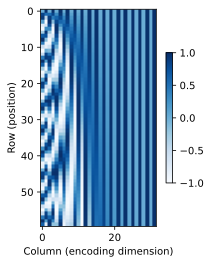

In [7]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

### 相对位置信息

除了捕获绝对位置信息之外，上述的位置编码还允许模型学习得到输入序列中相对位置信息。
这是因为对于任何确定的位置偏移$\delta$，位置$i + \delta$处
的位置编码可以线性投影位置$i$处的位置编码来表示。

这种投影的数学解释是，令$\omega_j = 1/10000^{2j/d}$，
对于任何确定的位置偏移$\delta$，
 :eqref:`eq_positional-encoding-def`中的任何一对
$(p_{i, 2j}, p_{i, 2j+1})$都可以线性投影到
$(p_{i+\delta, 2j}, p_{i+\delta, 2j+1})$：

$$\begin{aligned}
&\begin{bmatrix} \cos(\delta \omega_j) & \sin(\delta \omega_j) \\  -\sin(\delta \omega_j) & \cos(\delta \omega_j) \\ \end{bmatrix}
\begin{bmatrix} p_{i, 2j} \\  p_{i, 2j+1} \\ \end{bmatrix}\\
=&\begin{bmatrix} \cos(\delta \omega_j) \sin(i \omega_j) + \sin(\delta \omega_j) \cos(i \omega_j) \\  -\sin(\delta \omega_j) \sin(i \omega_j) + \cos(\delta \omega_j) \cos(i \omega_j) \\ \end{bmatrix}\\
=&\begin{bmatrix} \sin\left((i+\delta) \omega_j\right) \\  \cos\left((i+\delta) \omega_j\right) \\ \end{bmatrix}\\
=& 
\begin{bmatrix} p_{i+\delta, 2j} \\  p_{i+\delta, 2j+1} \\ \end{bmatrix},
\end{aligned}$$

$2\times 2$投影矩阵不依赖于任何位置的索引$i$。

## 小结

* 在自注意力中，查询、键和值都来自同一组输入。
* 卷积神经网络和自注意力都拥有并行计算的优势，而且自注意力的最大路径长度最短。但是因为其计算复杂度是关于序列长度的二次方，所以在很长的序列中计算会非常慢。
* 为了使用序列的顺序信息，我们可以通过在输入表示中添加位置编码，来注入绝对的或相对的位置信息。

## 练习

1. 假设我们设计一个深度架构，通过堆叠基于位置编码的自注意力层来表示序列。可能会存在什么问题？
1. 你能设计一种可学习的位置编码方法吗？


1. 上下文固定序列的缺陷
2. sin，cos里将替换成wi，wj